<a href="https://colab.research.google.com/github/alex-mat-s/VAE_practice/blob/main/VAE_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import random
import numpy as np
import imageio
import torch
import torchvision.transforms as transforms
from typing import Callable, Optional
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
import PIL
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image
import seaborn as sns

In [ ]:
sns.set_style("whitegrid")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alexandramatveeva","key":"74c3a24c5c1225e14222c3d7be682ad4"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d averkij/lfw-attributes

100% 6.49M/6.49M [00:01<00:00, 8.05MB/s]
100% 6.49M/6.49M [00:01<00:00, 5.03MB/s]


In [ ]:
!kaggle datasets download -d jessicali9530/lfw-dataset

100% 112M/112M [00:06<00:00, 19.8MB/s]
100% 112M/112M [00:06<00:00, 17.7MB/s]


In [ ]:
! mkdir attrib
! mkdir pics

In [ ]:
! unzip lfw-attributes.zip -d attrib
! unzip lfw-dataset.zip -d pics

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: pics/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg  
  inflating: pics/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg  
  inflating: pics/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg  
  inflating: pics/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg  
  inflating: pics/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0026.jpg  
  inflating: pics/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0027.jpg  
  inflating: pics/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0028.jpg  
  inflating: pics/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0029.jpg  
  inflating:

In [ ]:
DATASET_PATH ="pics/lfw-deepfunneled/lfw-deepfunneled/"
ATTRIBUTES_PATH = "attrib/lfw_attributes.txt"

PATH = "/content/drive/MyDrive/ITMO/AMLT'23/Task#3/"

### Explore the data

In [ ]:
dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})

dataset = pd.DataFrame(dataset)
dataset = dataset.groupby("person").filter(lambda x: len(x) < 25 )
dataset.head(10)

person  \
0                     Yang_Pao-yu   
1  Mireya_Elisa_Moscoso_Rodriguez   
2                    Martin_Frost   
3                     Kelli_White   
4                     Kelli_White   
5                    Steve_Coogan   
6                      Jeff_Roehm   
7                 Calvin_Harrison   
8              Wycliffe_Grousbeck   
9            Miguel_Aldana_Ibarra   

                                                path  
0  pics/lfw-deepfunneled/lfw-deepfunneled/Yang_Pa...  
1  pics/lfw-deepfunneled/lfw-deepfunneled/Mireya_...  
2  pics/lfw-deepfunneled/lfw-deepfunneled/Martin_...  
3  pics/lfw-deepfunneled/lfw-deepfunneled/Kelli_W...  
4  pics/lfw-deepfunneled/lfw-deepfunneled/Kelli_W...  
5  pics/lfw-deepfunneled/lfw-deepfunneled/Steve_C...  
6  pics/lfw-deepfunneled/lfw-deepfunneled/Jeff_Ro...  
7  pics/lfw-deepfunneled/lfw-deepfunneled/Calvin_...  
8  pics/lfw-deepfunneled/lfw-deepfunneled/Wycliff...  
9  pics/lfw-deepfunneled/lfw-deepfunneled/Miguel_...

<Axes: xlabel='person'>

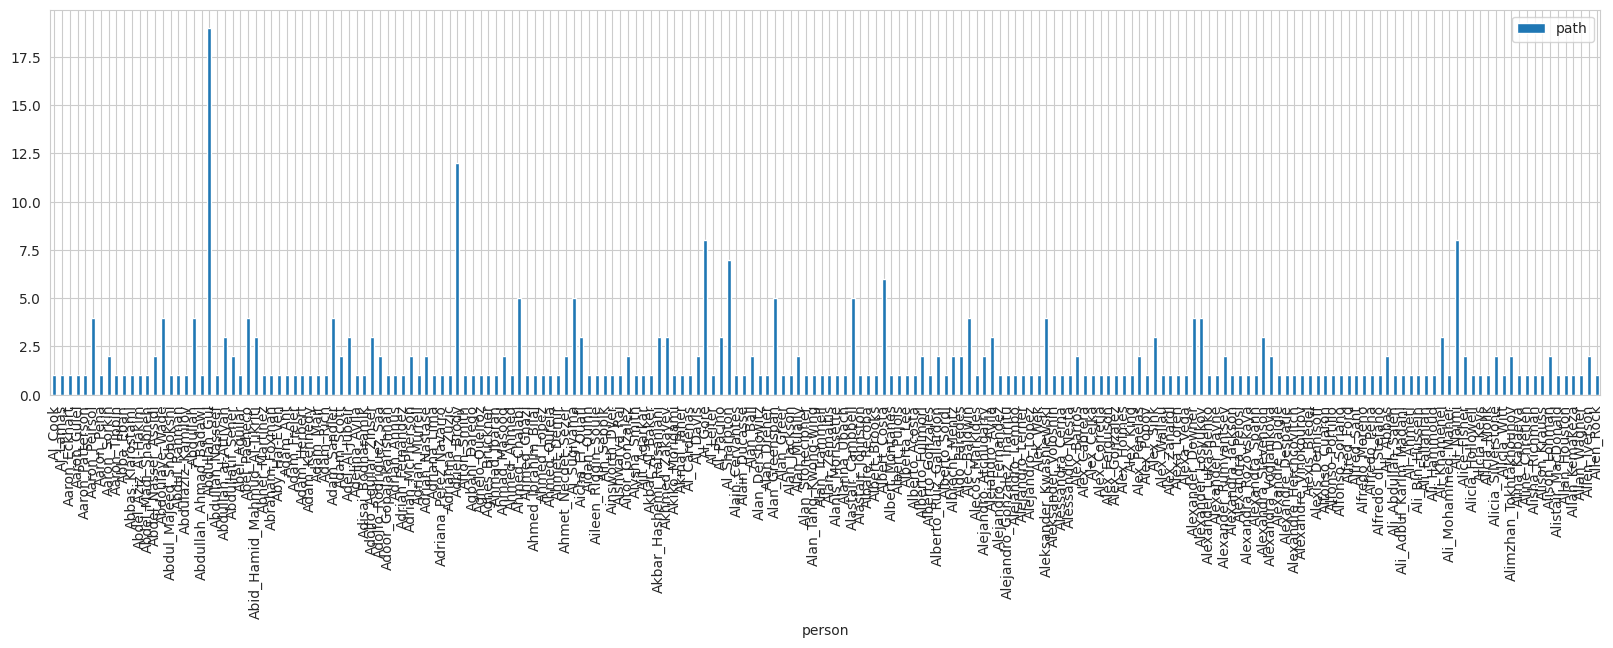

In [ ]:
dataset.groupby("person").count()[:200].plot(kind='bar', figsize=(20,5))

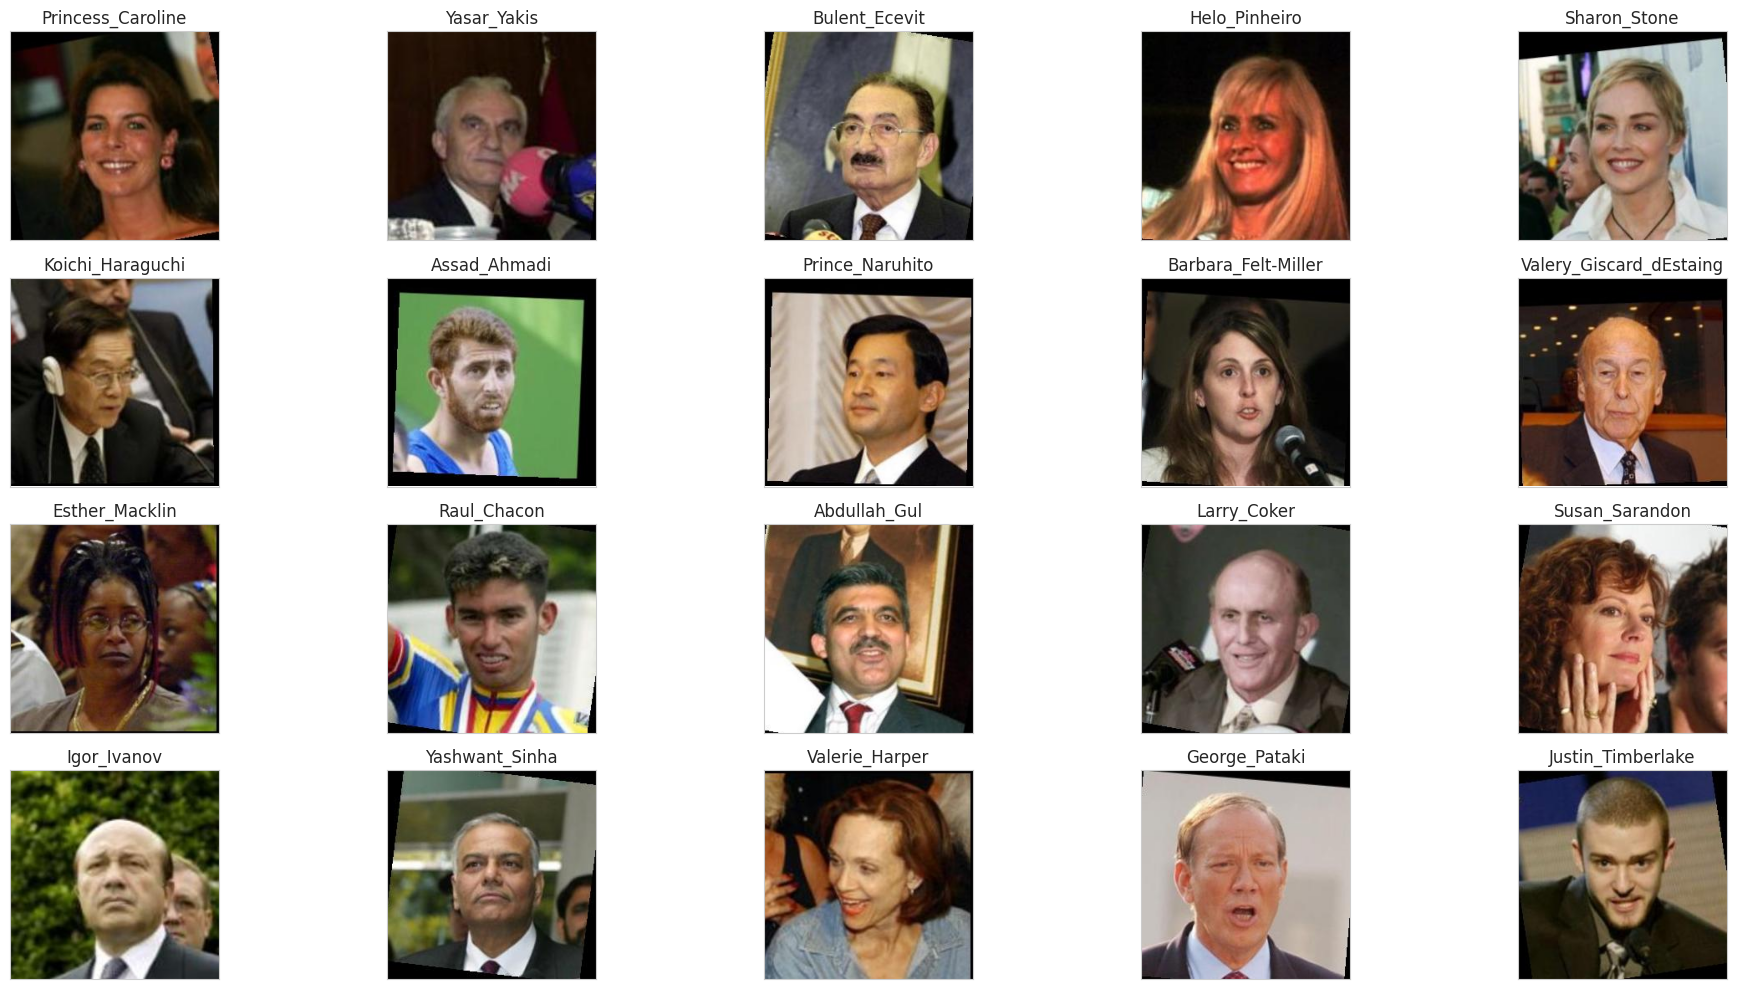

In [ ]:
plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(dataset))
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
# Code from https://debuggercafe.com/generating-fictional-celebrity-faces-using-convolutional-variational-autoencoder-and-pytorch/
to_pil_image = transforms.ToPILImage()

def image_to_vid(images):
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave(PATH+'generated_images.gif', imgs)


def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"{PATH}outputs/output{epoch}.jpg")


def save_loss_plot(train_loss, valid_loss):
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(PATH+'outputs/loss.jpg')
    plt.show()


### Prepare the dataset

In [ ]:
# Parameters
epochs = 75
batch_size = 128

In [ ]:
def fetch_dataset():
    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    rem_ids = []
    i = 0
    for path in df['photo_path']:
        try:
            imageio.imread(path)
        except AttributeError:
            rem_ids.append(i)
        i += 1
    df = df.drop(rem_ids)
    all_photos = df['photo_path'].apply(PIL.Image.open)
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
data, attrs = fetch_dataset()

<ipython-input-18-132b1134d9c2>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.imread(path)


In [307]:
data

0        <PIL.JpegImagePlugin.JpegImageFile image mode=...
1        <PIL.JpegImagePlugin.JpegImageFile image mode=...
2        <PIL.JpegImagePlugin.JpegImageFile image mode=...
3        <PIL.JpegImagePlugin.JpegImageFile image mode=...
4        <PIL.JpegImagePlugin.JpegImageFile image mode=...
                               ...                        
13138    <PIL.JpegImagePlugin.JpegImageFile image mode=...
13139    <PIL.JpegImagePlugin.JpegImageFile image mode=...
13140    <PIL.JpegImagePlugin.JpegImageFile image mode=...
13141    <PIL.JpegImagePlugin.JpegImageFile image mode=...
13142    <PIL.JpegImagePlugin.JpegImageFile image mode=...
Name: photo_path, Length: 13143, dtype: object

Training on cuda


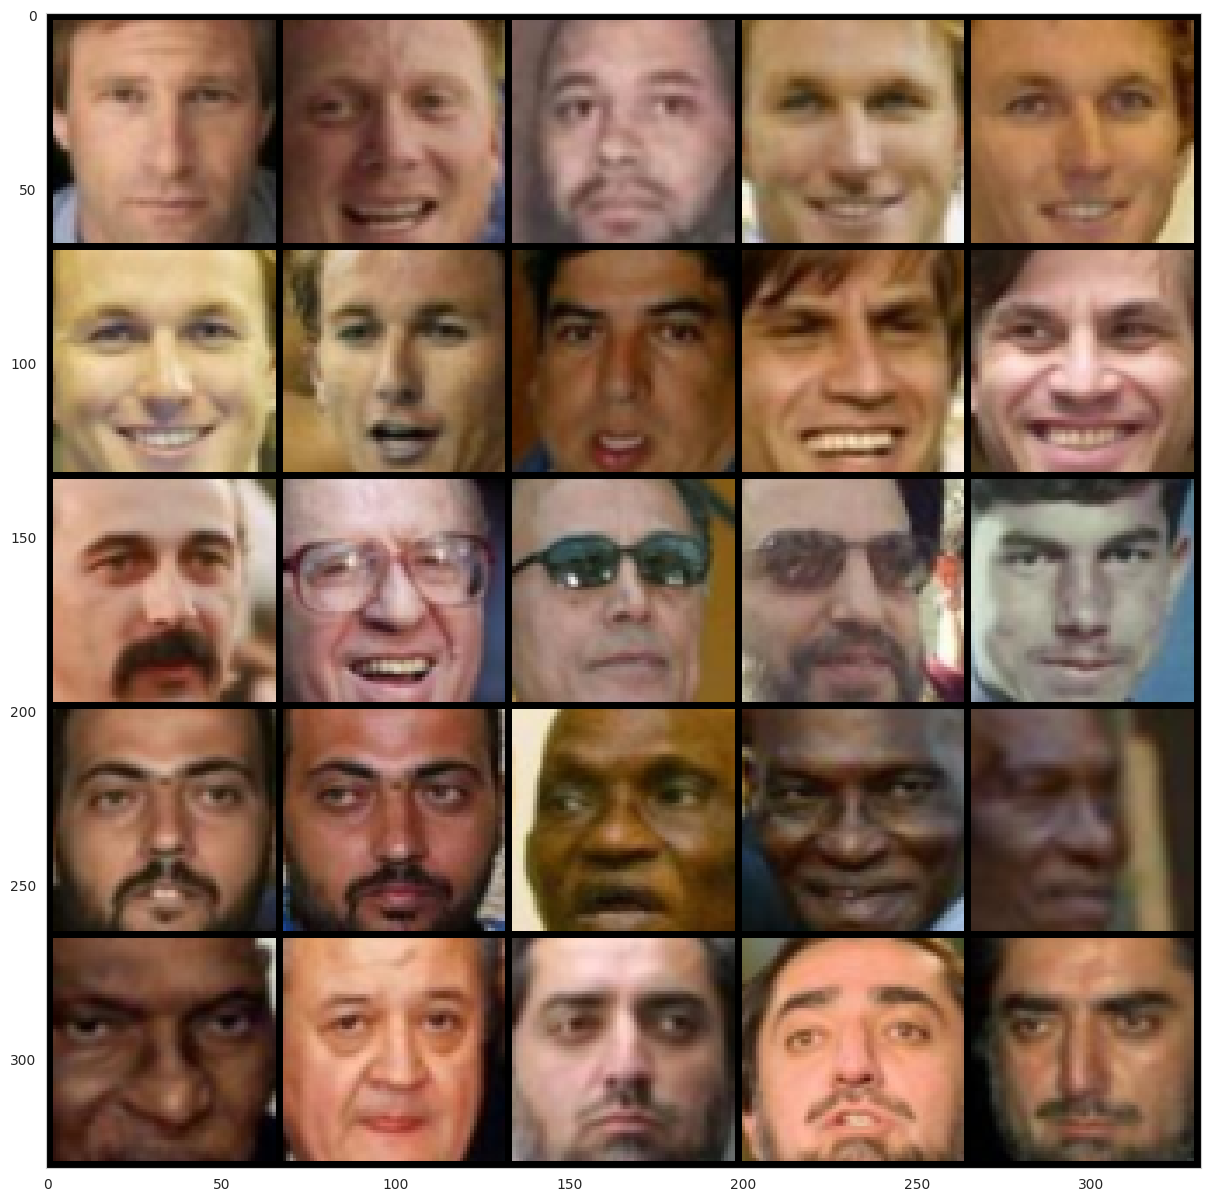

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on', device)

transform = transforms.Compose([ # Compose combines a number of transforms into one operation
    transforms.CenterCrop(100),
    transforms.Resize((64, 64)),
    transforms.ToTensor(), # PIL Image -> Tensor
    #transforms.Normalize([0.5], [0.5])
])

class Faces(torch.utils.data.Dataset):
    def __init__(self, data, transform: Optional[Callable] = None):
        super().__init__()
        self.transform = transform
        self.data = data
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx:int):
        img = self.data[idx]
        if self.transform: img = self.transform(img)
        return img

full_dataset = Faces(data, transform=transform)

# Train and valid split
trainset, validset = train_test_split(full_dataset, test_size=0.3, random_state=1234)

trainloader = torch.utils.data.DataLoader(dataset=trainset,
                                          batch_size=batch_size,
                                          shuffle=True)
                                          # drop_last=True)

validloader = torch.utils.data.DataLoader(dataset=validset,
                                          batch_size=batch_size)


from torchvision.utils import make_grid

plt.figure(figsize=(15,15))
plt.grid(False)
plt.imshow(make_grid([full_dataset[i] for i in range(25)], nrow=5).permute(1,2,0))

In [ ]:
it = next(iter(validloader))

In [ ]:
it[0].shape

torch.Size([3, 64, 64])

### Prepare VAE

In [ ]:
# The code is taken from https://github.com/ku2482/vae.pytorch
class Encoder(nn.Module):
    def __init__(self, nc, nef, nz, isize, device):
        super(Encoder, self).__init__()

        # Device
        self.device = device

        # Encoder: (nc, isize, isize) -> (nef*8, isize//16, isize//16)
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, nef, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef),

            nn.Conv2d(nef, nef*2, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*2),

            nn.Conv2d(nef*2, nef*4, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*4),

            nn.Conv2d(nef*4, nef*8, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*8)
        )

        # Map the encoded feature map to the latent vector of mean, (log)variance
        out_size = isize // 16
        self.mean = nn.Linear(nef*8*out_size*out_size, nz)
        self.logvar = nn.Linear(nef*8*out_size*out_size, nz)

    @staticmethod
    def reparametrize(mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, inputs):
        # Batch size
        batch_size = inputs.size(0)
        # Encoded feature map
        hidden = self.encoder(inputs)
        # Reshape
        hidden = hidden.view(batch_size, -1)
        # Calculate mean and (log)variance
        mean, logvar = self.mean(hidden), self.logvar(hidden)
        # Sample
        latent_z = self.reparametrize(mean, logvar)

        return latent_z, mean, logvar

class Decoder(nn.Module):
    def __init__(self, nc, ndf, nz, isize):
        super(Decoder, self).__init__()

        # Map the latent vector to the feature map space
        self.ndf = ndf
        self.out_size = isize // 16
        self.decoder_dense = nn.Sequential(
            nn.Linear(nz, ndf*8*self.out_size*self.out_size),
            nn.ReLU(True)
        )
        # Decoder: (ndf*8, isize//16, isize//16) -> (nc, isize, isize)
        self.decoder_conv = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*8, ndf*4, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*4, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*4, ndf*2, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*2, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*2, ndf, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf, nc, 3, padding=1)
        )

    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.decoder_dense(input).view(
            batch_size, self.ndf*8, self.out_size, self.out_size)
        output = self.decoder_conv(hidden)
        return output

class VAE(nn.Module):
    def __init__(self, nc=3, ndf=32, nef=32, nz=100, isize=64, device=torch.device("cuda:0"), is_train=True):
        super(VAE, self).__init__()

        self.nz = nz
        self.isize=isize
        # Encoder
        self.encoder = Encoder(nc=nc, nef=nef, nz=nz, isize=isize, device=device)
        # Decoder
        self.decoder = Decoder(nc=nc, ndf=ndf, nz=nz, isize=isize)

        if is_train == False:
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        latent_z, mean, logvar = self.encoder(x)
        rec_x = self.decoder(latent_z)
        return rec_x, mean, logvar

    def encode(self, x):
        latent_z, _, _ = self.encoder(x)
        return latent_z

    def decode(self, z):
        return self.decoder(z)

    @staticmethod
    def reparametrize(mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def sample(self, size):
        sample = torch.randn(size, self.nz).to(self.device)
        return model.decode(sample)

    @property
    def device(self): return next(self.parameters()).device

### Loss and Train Functions

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    batch_size = recon_x.shape[0]
    MSE = F.mse_loss(recon_x.view(batch_size,-1), x.view(batch_size, -1), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE, KLD


def train(model, dataloader, dataset, device, optimizer, loss_function):
    model.train()
    train_mse, train_kld, train_loss = 0, 0, 0
    counter = 0
    pbar = tqdm(total=int(len(dataset)/dataloader.batch_size), desc=f"[KL: ?] [MSE: ?]")

    for batch_idx, data in enumerate(dataloader):
        counter += 1
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        mse_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
        loss = mse_loss + kld_loss

        loss.backward()

        train_loss += loss.item()
        train_mse += mse_loss.item()
        train_kld += kld_loss.item()

        optimizer.step()

        pbar.set_description(f"[KL: {kld_loss.item()/len(data) :.2f}] [MSE: {mse_loss.item()/len(data): .2f}]")
        pbar.update(1)

    return train_loss / counter

### Validation Function

In [ ]:
def validate(model, dataloader, dataset, device, loss_function):
    model.eval()
    valid_mse, valid_kld, valid_loss = 0, 0, 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            counter += 1
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            mse_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
            loss = mse_loss + kld_loss

            valid_loss += loss.item()
            valid_mse += mse_loss.item()
            valid_kld += kld_loss.item()

            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = recon_batch

    val_loss = valid_loss / counter
    return val_loss, recon_images

### Train and Validate

In [ ]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
log_interval = 10

train_loss = []
valid_loss = []
# a list to save all the reconstructed images in PyTorch grid format
grid_images = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, trainloader, trainset, device, optimizer, loss_function
    )
    valid_epoch_loss, recon_images = validate(
        model, validloader, validset, device, loss_function
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)
    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)

    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

Epoch 1 of 75


[KL: 48.42] [MSE:  350.49]: : 72it [00:04, 15.84it/s]                      
31it [00:00, 87.20it/s]                        


Train Loss: 211679.3676
Val Loss: 45977.8761
Epoch 2 of 75


[KL: 44.45] [MSE:  195.89]: : 72it [00:02, 24.99it/s]
31it [00:00, 88.13it/s]                        


Train Loss: 34973.4572
Val Loss: 29156.3531
Epoch 3 of 75


[KL: 45.09] [MSE:  158.49]: : 72it [00:02, 24.13it/s]
31it [00:00, 84.75it/s]                        


Train Loss: 27799.3832
Val Loss: 25691.0539
Epoch 4 of 75


[KL: 44.65] [MSE:  152.21]: : 72it [00:02, 24.48it/s]
31it [00:00, 88.27it/s]                        


Train Loss: 24898.7019
Val Loss: 24526.9321
Epoch 5 of 75


[KL: 39.47] [MSE:  139.02]: : 72it [00:02, 25.02it/s]
31it [00:00, 87.70it/s]                        


Train Loss: 23539.3699
Val Loss: 22468.7840
Epoch 6 of 75


[KL: 37.91] [MSE:  128.45]: : 72it [00:02, 24.71it/s]
31it [00:00, 89.48it/s]                        


Train Loss: 22074.4132
Val Loss: 21237.5946
Epoch 7 of 75


[KL: 37.85] [MSE:  115.32]: : 72it [00:02, 24.87it/s]
31it [00:00, 85.89it/s]                        


Train Loss: 21047.2492
Val Loss: 20796.2455
Epoch 8 of 75


[KL: 37.75] [MSE:  124.79]: : 72it [00:02, 24.34it/s]
31it [00:00, 84.50it/s]                        


Train Loss: 20362.8331
Val Loss: 21678.8371
Epoch 9 of 75


[KL: 36.91] [MSE:  112.75]: : 72it [00:02, 24.99it/s]
31it [00:00, 88.38it/s]                        


Train Loss: 20009.5179
Val Loss: 19042.1781
Epoch 10 of 75


[KL: 36.71] [MSE:  114.27]: : 72it [00:02, 24.92it/s]
31it [00:00, 89.36it/s]                        


Train Loss: 19332.0779
Val Loss: 18896.0900
Epoch 11 of 75


[KL: 39.47] [MSE:  112.28]: : 72it [00:02, 24.79it/s]
31it [00:00, 86.73it/s]                        


Train Loss: 19307.0955
Val Loss: 19713.4803
Epoch 12 of 75


[KL: 37.56] [MSE:  126.14]: : 72it [00:02, 24.52it/s]
31it [00:00, 83.45it/s]                        


Train Loss: 18953.8169
Val Loss: 18671.4319
Epoch 13 of 75


[KL: 35.53] [MSE:  107.89]: : 72it [00:02, 24.81it/s]
31it [00:00, 88.92it/s]                        


Train Loss: 18804.4324
Val Loss: 19992.4057
Epoch 14 of 75


[KL: 38.48] [MSE:  103.99]: : 72it [00:02, 24.80it/s]
31it [00:00, 88.47it/s]                        


Train Loss: 18646.7059
Val Loss: 18806.8974
Epoch 15 of 75


[KL: 36.13] [MSE:  103.41]: : 72it [00:02, 24.64it/s]
31it [00:00, 86.74it/s]                        


Train Loss: 18082.0697
Val Loss: 18249.9325
Epoch 16 of 75


[KL: 36.38] [MSE:  99.47]: : 72it [00:03, 23.96it/s]
31it [00:00, 85.68it/s]                        


Train Loss: 17886.5870
Val Loss: 17791.1033
Epoch 17 of 75


[KL: 35.29] [MSE:  111.89]: : 72it [00:02, 24.17it/s]
31it [00:00, 89.94it/s]                        


Train Loss: 17711.6609
Val Loss: 17927.0915
Epoch 18 of 75


[KL: 37.96] [MSE:  101.95]: : 72it [00:02, 24.72it/s]
31it [00:00, 89.01it/s]                        


Train Loss: 17608.4972
Val Loss: 19784.2102
Epoch 19 of 75


[KL: 37.87] [MSE:  100.98]: : 72it [00:02, 24.62it/s]
31it [00:00, 88.97it/s]                        


Train Loss: 17679.0431
Val Loss: 17154.5715
Epoch 20 of 75


[KL: 35.06] [MSE:  89.07]: : 72it [00:02, 24.61it/s]
31it [00:00, 87.41it/s]                        


Train Loss: 17242.5444
Val Loss: 16723.3904
Epoch 21 of 75


[KL: 37.13] [MSE:  94.77]: : 72it [00:02, 24.17it/s]
31it [00:00, 87.82it/s]                        


Train Loss: 17198.0283
Val Loss: 16793.6558
Epoch 22 of 75


[KL: 35.72] [MSE:  106.85]: : 72it [00:02, 24.81it/s]
31it [00:00, 88.70it/s]                        


Train Loss: 16922.9820
Val Loss: 17949.4633
Epoch 23 of 75


[KL: 36.54] [MSE:  88.31]: : 72it [00:02, 24.79it/s]
31it [00:00, 88.97it/s]                        


Train Loss: 17224.4731
Val Loss: 17217.0840
Epoch 24 of 75


[KL: 36.02] [MSE:  88.83]: : 72it [00:02, 24.43it/s]
31it [00:00, 86.63it/s]                        


Train Loss: 16981.9140
Val Loss: 17809.0464
Epoch 25 of 75


[KL: 36.00] [MSE:  95.51]: : 72it [00:02, 24.27it/s]
31it [00:00, 81.26it/s]                        


Train Loss: 16800.5991
Val Loss: 17306.4987
Epoch 26 of 75


[KL: 35.82] [MSE:  93.27]: : 72it [00:02, 24.60it/s]
31it [00:00, 88.91it/s]                        


Train Loss: 17162.5440
Val Loss: 16567.0261
Epoch 27 of 75


[KL: 36.45] [MSE:  99.28]: : 72it [00:02, 24.61it/s]
31it [00:00, 88.42it/s]                        


Train Loss: 16513.5871
Val Loss: 16801.0607
Epoch 28 of 75


[KL: 37.28] [MSE:  94.71]: : 72it [00:02, 24.68it/s]
31it [00:00, 90.68it/s]                        


Train Loss: 16508.2697
Val Loss: 16337.1977
Epoch 29 of 75


[KL: 35.94] [MSE:  98.08]: : 72it [00:04, 15.82it/s]                      
31it [00:00, 85.95it/s]                        


Train Loss: 16472.4645
Val Loss: 16988.9335
Epoch 30 of 75


[KL: 36.02] [MSE:  87.66]: : 72it [00:02, 24.55it/s]
31it [00:00, 86.82it/s]                        


Train Loss: 16484.6895
Val Loss: 16041.9531
Epoch 31 of 75


[KL: 37.08] [MSE:  97.22]: : 72it [00:02, 24.56it/s]
31it [00:00, 89.12it/s]                        


Train Loss: 16115.6378
Val Loss: 15853.4699
Epoch 32 of 75


[KL: 36.66] [MSE:  89.13]: : 72it [00:02, 24.30it/s]
31it [00:00, 81.05it/s]                        


Train Loss: 16166.6204
Val Loss: 17450.5326
Epoch 33 of 75


[KL: 36.77] [MSE:  98.28]: : 72it [00:03, 23.41it/s]
31it [00:00, 85.24it/s]                        


Train Loss: 16233.4653
Val Loss: 16557.4378
Epoch 34 of 75


[KL: 35.11] [MSE:  92.31]: : 72it [00:02, 24.29it/s]
31it [00:00, 89.27it/s]                        


Train Loss: 16112.9333
Val Loss: 16203.1968
Epoch 35 of 75


[KL: 35.90] [MSE:  86.78]: : 72it [00:02, 24.68it/s]
31it [00:00, 89.15it/s]                        


Train Loss: 16113.0880
Val Loss: 16764.5374
Epoch 36 of 75


[KL: 34.76] [MSE:  89.78]: : 72it [00:02, 24.62it/s]
31it [00:00, 88.02it/s]                        


Train Loss: 16005.9152
Val Loss: 15871.7119
Epoch 37 of 75


[KL: 37.08] [MSE:  90.23]: : 72it [00:02, 24.11it/s]
31it [00:00, 84.71it/s]                        


Train Loss: 15941.3036
Val Loss: 15905.0646
Epoch 38 of 75


[KL: 35.72] [MSE:  85.67]: : 72it [00:02, 24.11it/s]
31it [00:00, 86.70it/s]                        


Train Loss: 15908.5413
Val Loss: 16357.3181
Epoch 39 of 75


[KL: 36.03] [MSE:  87.17]: : 72it [00:02, 24.56it/s]
31it [00:00, 85.83it/s]                        


Train Loss: 15791.0074
Val Loss: 17166.0398
Epoch 40 of 75


[KL: 35.16] [MSE:  94.54]: : 72it [00:02, 24.57it/s]
31it [00:00, 88.14it/s]                        


Train Loss: 15667.6985
Val Loss: 15787.8912
Epoch 41 of 75


[KL: 35.67] [MSE:  85.54]: : 72it [00:02, 24.47it/s]
31it [00:00, 86.30it/s]                        


Train Loss: 15478.7952
Val Loss: 15439.1827
Epoch 42 of 75


[KL: 35.92] [MSE:  85.61]: : 72it [00:03, 23.97it/s]
31it [00:00, 88.24it/s]                        


Train Loss: 15772.8324
Val Loss: 16722.7821
Epoch 43 of 75


[KL: 35.97] [MSE:  82.94]: : 72it [00:02, 24.50it/s]
31it [00:00, 88.17it/s]                        


Train Loss: 15685.7415
Val Loss: 15796.5330
Epoch 44 of 75


[KL: 35.43] [MSE:  86.09]: : 72it [00:02, 24.51it/s]
31it [00:00, 89.44it/s]                        


Train Loss: 15766.8325
Val Loss: 16363.7679
Epoch 45 of 75


[KL: 35.12] [MSE:  83.45]: : 72it [00:02, 24.67it/s]
31it [00:00, 84.99it/s]                        


Train Loss: 15586.7881
Val Loss: 16037.0141
Epoch 46 of 75


[KL: 35.77] [MSE:  92.21]: : 72it [00:03, 23.57it/s]
31it [00:00, 82.77it/s]                        


Train Loss: 15588.1370
Val Loss: 16193.7861
Epoch 47 of 75


[KL: 34.71] [MSE:  79.22]: : 72it [00:02, 24.35it/s]
31it [00:00, 88.38it/s]                        


Train Loss: 15377.2605
Val Loss: 15279.7597
Epoch 48 of 75


[KL: 35.81] [MSE:  85.68]: : 72it [00:02, 24.43it/s]
31it [00:00, 87.76it/s]                        


Train Loss: 15368.7800
Val Loss: 15281.9468
Epoch 49 of 75


[KL: 36.91] [MSE:  78.95]: : 72it [00:02, 24.66it/s]
31it [00:00, 89.63it/s]                        


Train Loss: 15353.4419
Val Loss: 15992.7812
Epoch 50 of 75


[KL: 36.27] [MSE:  80.89]: : 72it [00:03, 22.60it/s]
31it [00:00, 44.00it/s]


Train Loss: 15210.2604
Val Loss: 15636.1019
Epoch 51 of 75


[KL: 34.98] [MSE:  82.09]: : 72it [00:04, 15.76it/s]
31it [00:00, 61.47it/s]                        


Train Loss: 15211.5508
Val Loss: 15143.2543
Epoch 52 of 75


[KL: 35.57] [MSE:  89.95]: : 72it [00:03, 18.10it/s]                      
31it [00:00, 80.50it/s]                        


Train Loss: 15159.9979
Val Loss: 15933.2318
Epoch 53 of 75


[KL: 36.78] [MSE:  79.71]: : 72it [00:03, 21.93it/s]                      
31it [00:00, 63.44it/s]                        


Train Loss: 15098.6956
Val Loss: 15393.0649
Epoch 54 of 75


[KL: 35.40] [MSE:  83.19]: : 72it [00:04, 16.57it/s]
31it [00:00, 85.08it/s]                        


Train Loss: 15123.0419
Val Loss: 15297.9987
Epoch 55 of 75


[KL: 35.69] [MSE:  82.38]: : 72it [00:02, 24.30it/s]
31it [00:00, 88.90it/s]                        


Train Loss: 15152.6790
Val Loss: 16353.5799
Epoch 56 of 75


[KL: 34.81] [MSE:  79.54]: : 72it [00:02, 24.45it/s]
31it [00:00, 88.55it/s]                        


Train Loss: 15283.2727
Val Loss: 15068.7639
Epoch 57 of 75


[KL: 33.95] [MSE:  84.63]: : 72it [00:02, 24.49it/s]
31it [00:00, 88.46it/s]                        


Train Loss: 14998.7600
Val Loss: 15063.4952
Epoch 58 of 75


[KL: 35.22] [MSE:  79.32]: : 72it [00:03, 23.95it/s]
31it [00:00, 84.27it/s]                        


Train Loss: 15087.5779
Val Loss: 15311.5747
Epoch 59 of 75


[KL: 35.81] [MSE:  82.12]: : 72it [00:02, 24.42it/s]
31it [00:00, 88.85it/s]                        


Train Loss: 15255.4445
Val Loss: 15300.3944
Epoch 60 of 75


[KL: 34.51] [MSE:  76.12]: : 72it [00:02, 24.65it/s]
31it [00:00, 87.30it/s]                        


Train Loss: 14889.4715
Val Loss: 15303.6545
Epoch 61 of 75


[KL: 35.06] [MSE:  85.13]: : 72it [00:02, 24.70it/s]
31it [00:00, 90.49it/s]                        


Train Loss: 14902.8575
Val Loss: 14801.0662
Epoch 62 of 75


[KL: 36.42] [MSE:  92.49]: : 72it [00:03, 23.64it/s]
31it [00:00, 82.56it/s]                        


Train Loss: 14831.9465
Val Loss: 15292.8644
Epoch 63 of 75


[KL: 34.88] [MSE:  90.14]: : 72it [00:03, 23.78it/s]
31it [00:00, 87.10it/s]                        


Train Loss: 14914.7533
Val Loss: 15063.3697
Epoch 64 of 75


[KL: 35.61] [MSE:  86.05]: : 72it [00:02, 24.37it/s]
31it [00:00, 89.70it/s]                        


Train Loss: 14913.5995
Val Loss: 15106.7197
Epoch 65 of 75


[KL: 35.16] [MSE:  78.86]: : 72it [00:02, 24.56it/s]
31it [00:00, 87.63it/s]                        


Train Loss: 14962.6810
Val Loss: 15596.7259
Epoch 66 of 75


[KL: 36.26] [MSE:  82.98]: : 72it [00:02, 24.02it/s]
31it [00:00, 82.48it/s]                        


Train Loss: 14842.7734
Val Loss: 14877.7265
Epoch 67 of 75


[KL: 36.84] [MSE:  89.11]: : 72it [00:03, 23.93it/s]
31it [00:00, 83.31it/s]                        


Train Loss: 14724.0280
Val Loss: 15727.6267
Epoch 68 of 75


[KL: 35.93] [MSE:  80.47]: : 72it [00:03, 23.58it/s]
31it [00:00, 86.29it/s]                        


Train Loss: 14757.2778
Val Loss: 15012.8776
Epoch 69 of 75


[KL: 35.43] [MSE:  80.12]: : 72it [00:02, 24.31it/s]
31it [00:00, 88.82it/s]                        


Train Loss: 14684.1364
Val Loss: 15624.2400
Epoch 70 of 75


[KL: 36.26] [MSE:  86.61]: : 72it [00:03, 23.80it/s]
31it [00:00, 88.73it/s]                        


Train Loss: 14867.3406
Val Loss: 14999.7939
Epoch 71 of 75


[KL: 35.27] [MSE:  81.51]: : 72it [00:03, 23.89it/s]
31it [00:00, 86.63it/s]                        


Train Loss: 14806.6639
Val Loss: 15091.5473
Epoch 72 of 75


[KL: 37.23] [MSE:  78.80]: : 72it [00:02, 24.03it/s]
31it [00:00, 86.38it/s]                        


Train Loss: 14734.1286
Val Loss: 15117.4642
Epoch 73 of 75


[KL: 35.47] [MSE:  76.57]: : 72it [00:02, 24.22it/s]
31it [00:00, 87.44it/s]                        


Train Loss: 14629.4615
Val Loss: 14814.5501
Epoch 74 of 75


[KL: 36.22] [MSE:  75.92]: : 72it [00:03, 23.88it/s]
31it [00:00, 87.34it/s]                        


Train Loss: 14752.0509
Val Loss: 15384.8415
Epoch 75 of 75


[KL: 37.08] [MSE:  89.89]: : 72it [00:04, 15.65it/s]
31it [00:01, 29.23it/s]                        


Train Loss: 14644.8120
Val Loss: 14766.2019


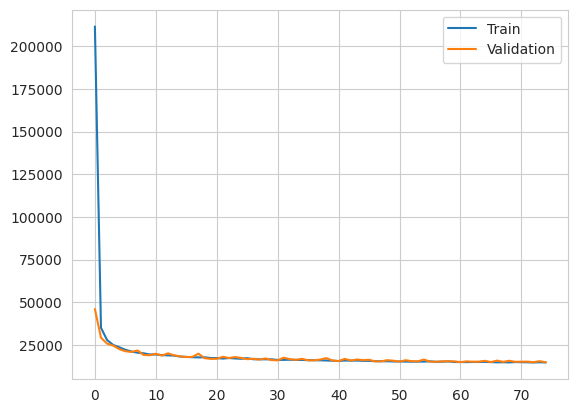

In [ ]:
plt.plot(train_loss, label="Train")
plt.plot(valid_loss, label="Validation")
plt.legend()

In [ ]:
model

VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mean): Linear(in_features=4096, out_f

In [ ]:
# Get the video
image_to_vid(grid_images)

In [ ]:
# Save the model
torch.save(model.state_dict(), PATH+"cnn_model")

Text(0.5, 1.0, 'Initial image')

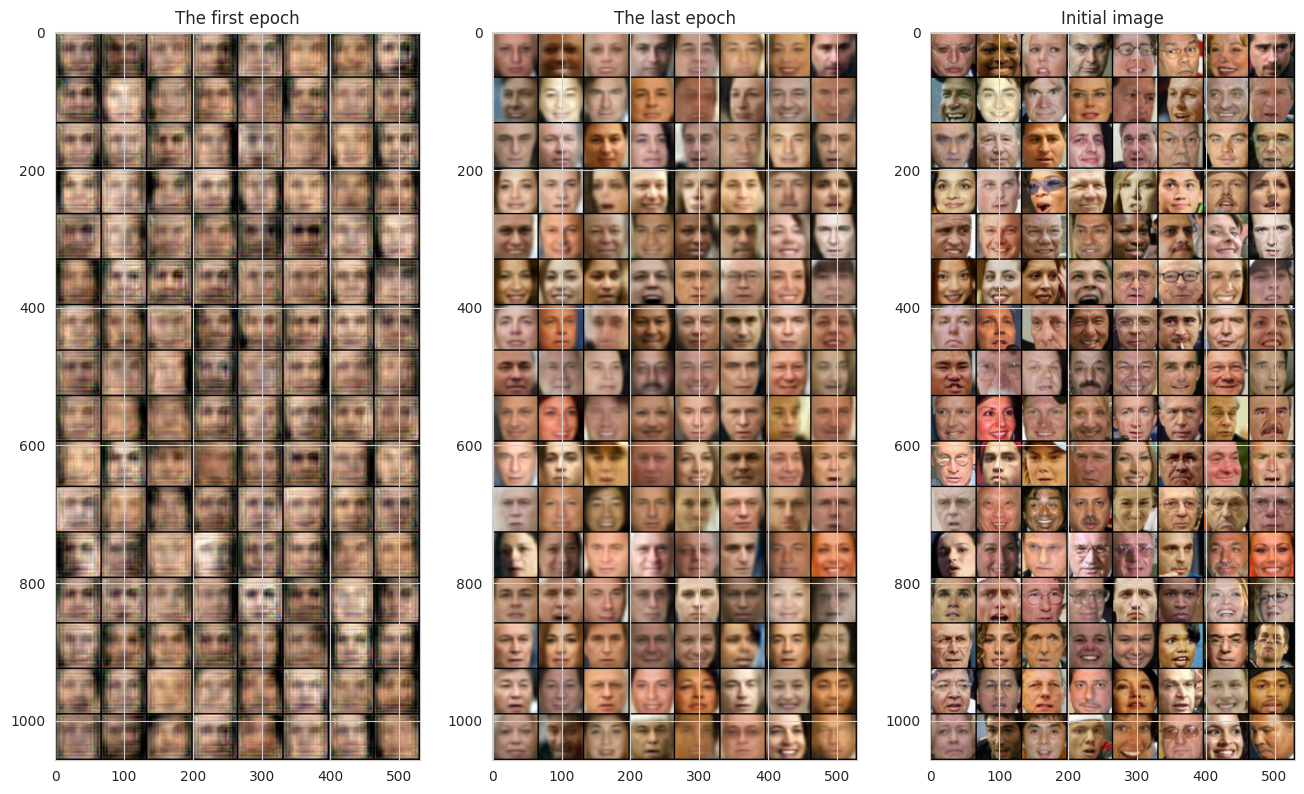

In [ ]:
# Plot one example
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 10))
ax1.imshow(make_grid([grid_images[0][i] for i in range(len(grid_images[0]))], nrow=5
                     ).permute(1,2,0))
ax1.set_title("The first epoch")
ax2.imshow(make_grid([grid_images[-1][i] for i in range(len(grid_images[-1]))], nrow=5).permute(1,2,0))
ax2.set_title("The last epoch")

it = iter(validloader)
counter = 0
for i in range(len(validloader)):
    counter += 1
    if i == int(len(validset)/validloader.batch_size) - 1:
        batch = next(it)
        break
    else:
        next(it)

ax3.imshow(make_grid([batch[i] for i in range((len(batch)))], nrow=8).permute(1,2,0))
ax3.set_title("Initial image")

### Shaving and smiling function

Develop a function for “shaving” and “smiling” the face of a man on the input picture: input – should be the image with a man with a beard and/or mustache without a smile, output – should be the image with the same man but already shaved and smiling.

In [275]:
def plot_gallery(data, n):
    plt.figure(figsize=(10,10))
    plt.grid(False)
    plt.imshow(make_grid([data[i] for i in range(n)], nrow=5).permute(1,2,0))

In [276]:
model = VAE().to(device)
#model.load_state_dict(torch.load(PATH+"cnn_model"))
model.load_state_dict(torch.load("/content/drive/MyDrive/ITMO/AMLT'23/Task3/cnn_model"))
model.eval()

VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mean): Linear(in_features=4096, out_f

In [277]:
attrs.head()

Male     Asian     White     Black      Baby     Child     Youth  \
0  1.568346 -1.889043  1.737203 -0.929729 -1.471799  -0.19558 -0.835609   
1  0.169851 -0.982408  0.422709 -1.282184  -1.36006 -0.867002 -0.452293   
2  0.997749 -1.364195 -0.157377 -0.756447 -1.891825 -0.871526 -0.862893   
3  1.122719 -1.997799  1.916144 -2.514214 -2.580071 -1.404239  0.057551   
4  1.078214 -2.008098  1.676211 -2.278056 -2.651845 -1.348408  0.649089   

  Middle Aged    Senior Black Hair  ... Pale Skin 5 o' Clock Shadow  \
0   -0.351468 -1.012533  -0.719593  ...  0.361738          1.166118   
1   -0.197521 -0.956073  -0.802107  ... -0.832036          -0.39768   
2    0.031445 -1.341523  -0.090037  ...  1.549743          1.884745   
3    0.000196 -1.273512  -1.431462  ...  0.567822         -0.176089   
4    0.017656 -1.889111  -1.857213  ... -1.461474         -0.955283   

  Strong Nose-Mouth Lines Wearing Lipstick Flushed Face High Cheekbones  \
0               -1.164916         -1.13999    -2.371746       -1.299932   
1                 0.87416        -0.945431    -0.268649       -0.006244   
2               -0.999765        -1.359858    -1.912108       -1.095634   
3                1.108125        -1.600944    -3.264613        0.813418   
4                0.119113        -1.128176    -3.161048         0.08268   

  Brown Eyes Wearing Earrings Wearing Necktie Wearing Necklace  
0  -0.414682        -1.144902        0.694007        -0.826609  
1  -0.030406        -0.480128         0.66676        -0.496559  
2   0.915126        -0.572332        0.144262        -0.841231  
3   0.308631        -0.848693        0.475941        -0.447025  
4  -0.439614        -0.359859       -0.760774        -0.410152  

[5 rows x 73 columns]

In [278]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [293]:
men_ids = attrs.Male.sort_values(ascending=False).iloc[:5000].index.values
men_attrs = attrs.loc[men_ids]
men_data = data[men_ids]

smile_men_ids = men_attrs.Smiling.sort_values(ascending=False).head(25).index.values
smile_men_data = data[smile_men_ids]

no_smile_men_ids = men_attrs.Smiling.sort_values(ascending=True).head(25).index.values
no_smile_men_data = data[no_smile_men_ids]

mustache_men_ids = men_attrs.Mustache.sort_values(ascending=False).head(25).index.values
mustache_men_data = data[mustache_men_ids]

no_mustache_men_ids = men_attrs.Mustache.sort_values(ascending=True).head(25).index.values
no_mustache_men_data = data[no_mustache_men_ids]

no_beard_men_ids = men_attrs["No Beard"].sort_values(ascending=False).head(25).index.values
no_beard_men_data = data[no_beard_men_ids]

beard_men_ids = men_attrs["No Beard"].sort_values(ascending=True).head(25).index.values
beard_men_data = data[beard_men_ids]

# Get data No Smile with beard and mustache
men_no_smile_ids = men_attrs.sort_values(by=["Smiling"], ascending=True).head(1000).index.values
men_no_smile_attrs = attrs.iloc[men_no_smile_ids]

men_no_smile_mustache_ids = men_no_smile_attrs.sort_values(by=["Mustache"], ascending=False).head(50).index.values
men_no_smile_mustache_attrs = attrs.iloc[men_no_smile_mustache_ids]

men_no_smile_mustache_beard_ids = men_no_smile_mustache_attrs.sort_values(by=["No Beard"], ascending=True).head(25).index.values
men_no_smile_mustache_beard_data = data[men_no_smile_mustache_beard_ids]

In [294]:
men_data.index = [i for i in range(len(men_data))]
smile_men_data.index = [i for i in range(len(smile_men_data))]
no_smile_men_data.index = [i for i in range(len(no_smile_men_data))]
mustache_men_data.index = [i for i in range(len(mustache_men_data))]
no_mustache_men_data.index = [i for i in range(len(no_mustache_men_data))]
no_beard_men_data.index = [i for i in range(len(no_beard_men_data))]
beard_men_data.index = [i for i in range(len(beard_men_data))]

men_no_smile_mustache_beard_data.index = [i for i in range(len(men_no_smile_mustache_beard_data))]

In [295]:
men_dataset = Faces(men_data, transform=transform)
smile_men_dataset = Faces(smile_men_data, transform=transform)
no_smile_men_dataset = Faces(no_smile_men_data, transform=transform)
mustache_men_dataset = Faces(mustache_men_data, transform=transform)
no_mustache_men_dataset = Faces(no_mustache_men_data, transform=transform)
no_beard_men_dataset = Faces(no_beard_men_data, transform=transform)
beard_men_dataset = Faces(beard_men_data, transform=transform)

men_no_smile_mustache_beard_dataset = Faces(men_no_smile_mustache_beard_data, transform=transform)

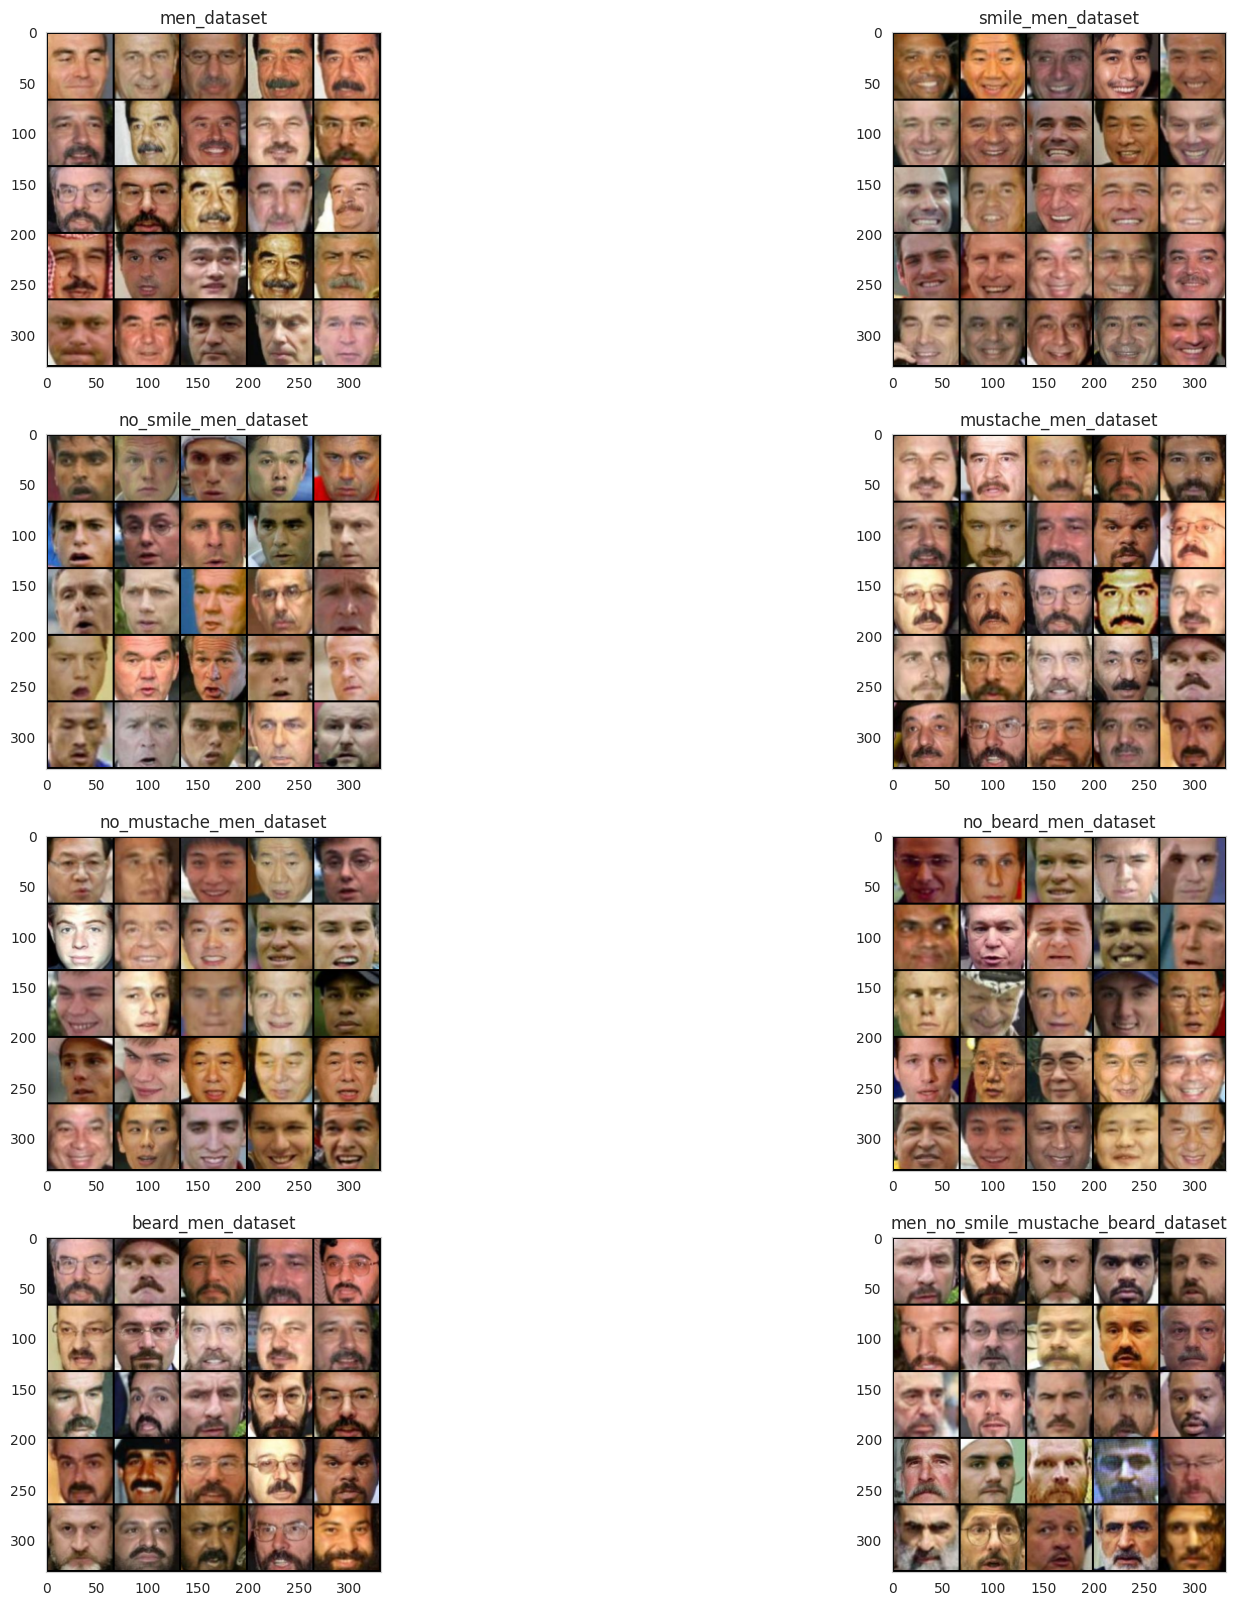

In [296]:
# Plot all samples
fig, axs = plt.subplots(4, 2, figsize=(20, 20))

datasets_lst = [men_dataset, smile_men_dataset, no_smile_men_dataset,
                mustache_men_dataset, no_mustache_men_dataset, no_beard_men_dataset,
                beard_men_dataset, men_no_smile_mustache_beard_dataset]
datasets_names = ["men_dataset", "smile_men_dataset", "no_smile_men_dataset",
                "mustache_men_dataset", "no_mustache_men_dataset", "no_beard_men_dataset",
                  "beard_men_dataset", "men_no_smile_mustache_beard_dataset"]

for i, dataset in enumerate(datasets_lst):


    axs[i//2, i % 2].grid(False)
    axs[i//2, i % 2].imshow(make_grid([dataset[i] for i in range(25)], nrow=5).permute(1,2,0))

    axs[i//2, i % 2].set_title(datasets_names[i])


In [297]:
# Calculating latent space vector for the selected images
def to_latent(dataloader, model, device, batch_size):
    model.eval()
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            data = data.to(device)
            recon_batch = model.encode(data)
    return recon_batch

def from_latent(vec, device, model):
    model.eval()
    with torch.no_grad():
        inputs = vec.to(device)
        output = model.decode(inputs)
        return output

In [298]:
def calculate_mean(latent, device):
    mean_tensor = torch.zeros(latent[0].size()).to(device)

    for tensor in latent:
        mean_tensor += tensor
    mean_tensor /= len(latent)

    return mean_tensor

In [327]:
def shave_make_me_smile(data, smile_vec, beard_vec, mustache_vec, transform, model):
    pics_output = []
    for pic in data:
        pic = pd.Series(pic)
        dataset = Faces(pic, transform=transform)
        dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                                 batch_size=1)

        latent_vec = to_latent(dataloader, model, device, batch_size=1)
        latent_vec[0] -= beard_vec
        latent_vec[0] -= mustache_vec
        latent_vec[0] += smile_vec
        pic_output = from_latent(latent_vec, device, model)

        image_grid = make_grid(pic_output.detach().cpu())
        pics_output.append(image_grid)
    return pics_output

In [317]:
smileloader = torch.utils.data.DataLoader(dataset=smile_men_dataset,
                                          batch_size=len(smile_men_dataset),
                                          shuffle=True)
no_smileloader = torch.utils.data.DataLoader(dataset=no_smile_men_dataset,
                                             batch_size=len(no_smile_men_dataset),
                                             shuffle=True)
beardloader = torch.utils.data.DataLoader(dataset=beard_men_dataset,
                                          batch_size=len(beard_men_dataset),
                                          shuffle=True)
no_beardloader = torch.utils.data.DataLoader(dataset=no_beard_men_dataset,
                                             batch_size=len(no_beard_men_dataset),
                                             shuffle=True)
mustacheloader = torch.utils.data.DataLoader(dataset=mustache_men_dataset,
                                             batch_size=len(mustache_men_dataset),
                                             shuffle=True)
no_mustacheloader = torch.utils.data.DataLoader(dataset=no_mustache_men_dataset,
                                             batch_size=len(no_mustache_men_dataset),
                                             shuffle=True)

In [318]:
smile_latent = to_latent(smileloader, model, device, batch_size=len(smile_men_dataset))
smile_latent = calculate_mean(smile_latent, device)

no_smile_latent = to_latent(no_smileloader, model, device, batch_size=len(no_smile_men_dataset))
no_smile_latent = calculate_mean(no_smile_latent, device)

beard_latent = to_latent(beardloader, model, device, batch_size=len(beard_men_dataset))
beard_latent = calculate_mean(beard_latent, device)

no_beard_latent = to_latent(no_beardloader, model, device, batch_size=len(no_beard_men_dataset))
no_beard_latent = calculate_mean(no_beard_latent, device)

mustache_latent = to_latent(mustacheloader, model, device, batch_size=len(mustache_men_dataset))
mustache_latent = calculate_mean(mustache_latent, device)

no_mustache_latent = to_latent(no_mustacheloader, model, device, batch_size=len(no_mustache_men_dataset))
no_mustache_latent = calculate_mean(no_mustache_latent, device)

smile_vec = smile_latent - no_smile_latent
beard_vec = beard_latent - no_beard_latent
mustache_vec = mustache_latent - no_mustache_latent

100%|██████████| 1/1 [00:00<00:00, 14.97it/s]


In [328]:
pics = shave_make_me_smile(men_no_smile_mustache_beard_data, smile_vec, beard_vec, mustache_vec, transform, model)

  4%|▍         | 1/25 [00:00<00:00, 427.64it/s]


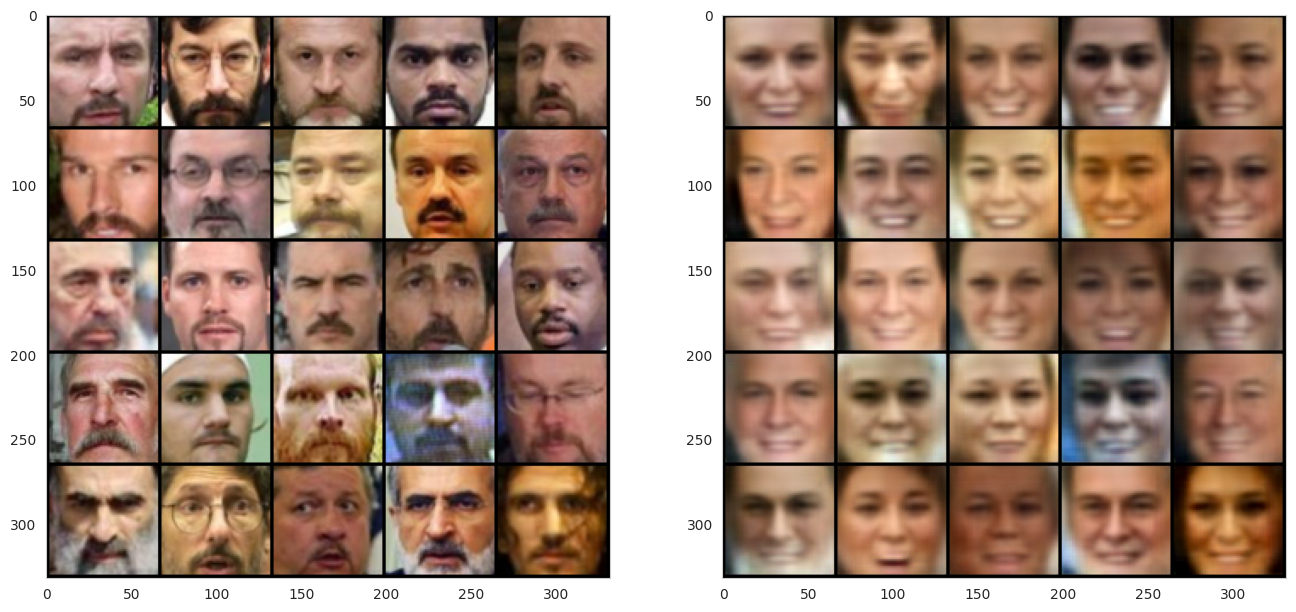

In [329]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
ax1.grid(False)
ax2.grid(False)
ax1.imshow(make_grid([men_no_smile_mustache_beard_dataset[i] for i in range(25)], nrow=5).permute(1,2,0))

ax2.imshow(make_grid([pics[i] for i in range(25)], nrow=5).permute(1,2,0))

### Custom Image

  4%|▍         | 1/25 [00:00<00:00, 228.17it/s]


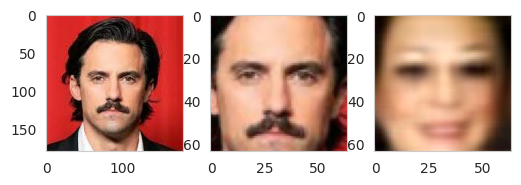

In [351]:
test_img = PIL.Image.open("/content/drive/MyDrive/ITMO/AMLT'23/Task3/test_2.jpeg")
test_img = pd.Series([test_img])
test_dataset = Faces(test_img, transform=transform)

test_img_res = shave_make_me_smile(test_img, smile_vec, beard_vec, mustache_vec, transform, model)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 3))
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)

ax1.imshow(np.asarray(test_img.iloc[0]))
ax2.imshow(make_grid([test_dataset[0]], nrow=1).permute(1,2,0))
ax3.imshow(make_grid([test_img_res[0]], nrow=1).permute(1,2,0))